In [2]:
!pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 80.0 MB/s eta 0:00:00


In [23]:
import fitz  # PyMuPDF
import os
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_predict
import joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def get_color_str(color):
    return f"rgb({color[0]*255:.0f},{color[1]*255:.0f},{color[2]*255:.0f})"


In [5]:
def extract_highlighted_text_by_color(pdf_path):
    doc = fitz.open(pdf_path)
    highlighted_text_by_color = {}

    for page_num in range(len(doc)):
        page = doc[page_num]
        annotations = page.annots()
        if annotations:
            for annot in annotations:
                if annot.type[0] == 8:  # Highlight annotation
                    color = annot.colors['stroke'] if 'stroke' in annot.colors else annot.colors['fill']
                    color_str = get_color_str(color)
                    if color_str not in highlighted_text_by_color:
                        highlighted_text_by_color[color_str] = []
                    quadpoints = annot.vertices
                    quads = [quadpoints[i:i + 4] for i in range(0, len(quadpoints), 4)]
                    for quad in quads:
                        rect = fitz.Quad(quad).rect
                        words = page.get_text("words", clip=rect)
                        words.sort(key=lambda w: (w[1], w[0]))  # sort by y, then by x
                        highlighted_text_by_color[color_str].append(" ".join(w[4] for w in words))

    return highlighted_text_by_color

In [6]:
# Extract training data from highlighted PDFs
def prepare_training_data(directory_path):
    training_data = []
    labels = []
    pdf_files = [f for f in os.listdir(directory_path) if f.endswith('.pdf')]

    for pdf_file in pdf_files:
        pdf_path = os.path.join(directory_path, pdf_file)
        highlights_by_color = extract_highlighted_text_by_color(pdf_path)

        for color, texts in highlights_by_color.items():
            if color == 'rgb(255,240,102)':  # GRI Index Table
                for text in texts:
                    training_data.append(text)
                    labels.append('GRI_Index')
            elif color == 'rgb(143,222,249)':  # Page references in GRI Index
                for text in texts:
                    training_data.append(text)
                    labels.append('Page_Ref')

    return training_data, labels

In [19]:
# Train the model
def train_model(training_data, labels):
    vectorizer = TfidfVectorizer()
    classifier = LogisticRegression()
    model = make_pipeline(vectorizer, classifier)
    model.fit(training_data, labels)
    joblib.dump(model, 'gri_model.pkl')
    return model # Added return statement to return the trained model

In [20]:
# Predict using the model
def predict_with_model(pdf_path, model_path='gri_model.pkl'):
    model = joblib.load(model_path)
    doc = fitz.open(pdf_path)
    gri_index_tables = []
    page_references = []

    for page_num in range(len(doc)):
        page = doc[page_num]
        text = page.get_text("text")
        predictions = model.predict([text])

        if 'GRI_Index' in predictions:
            gri_index_tables.append((page_num + 1, text))
        if 'Page_Ref' in predictions:
            page_references.append((page_num + 1, text))

    return gri_index_tables, page_references


In [21]:
# Example usage
directory_path = '/content/dataset'  # Directory containing the training PDFs
training_data, labels = prepare_training_data(directory_path)
X_train, X_test, y_train, y_test = train_test_split(training_data, labels, test_size=0.2, random_state=42)

Classification Report:
              precision    recall  f1-score   support

   GRI_Index       0.79      1.00      0.88       121
    Page_Ref       1.00      0.29      0.45        45

    accuracy                           0.81       166
   macro avg       0.90      0.64      0.67       166
weighted avg       0.85      0.81      0.77       166

Confusion Matrix:


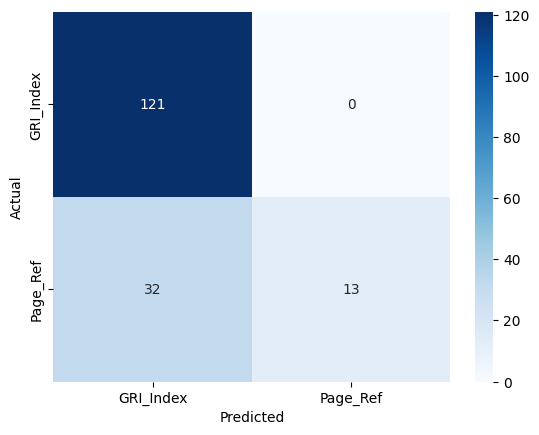

Accuracy: 0.8072289156626506


In [22]:
model = train_model(X_train, y_train)
evaluate_model(model, X_test, y_test)

In [10]:
# Predict on a new PDF
new_pdf_path = '/content/350351_1.pdf'
gri_index_tables, page_references = predict_with_model(new_pdf_path)

In [11]:
print("GRI Index Tables:")
for page, table in gri_index_tables:
    print(f"Page {page}:\n{table}\n")

print("Page References:")
for page, ref in page_references:
    print(f"Page {page}:\n{ref}\n")

GRI Index Tables:
Page 1:
1
F-I-R-S-T Carbon Solutions 2016 
Sustainability Report
Big Data, the Blueprint of Sustainable Development Goals (SDGs)


Page 2:
2
F-I-R-S-T CARBON SOLUTIONS 2016 SUSTAINABILITY REPORT I ABOUT THE COVER
ABOUT THE COVER
The hexagon is a shape that naturally occurs in nature, specifically in the honeycomb found 
in beehives. The honeycomb is often associated with hard work, organization and efficiency 
as demonstrated by the worker bees.
The creation of the honeycomb entails a process called “tessellation”, or the arranging 
 
of polygons in a manner where they are closely fitted together. This results to patterns 
without gaps, which means no unused space. For bees, tessellation ensures that space 
inside the hive is maximized and that there are no wasted resources.
From a data standpoint, the hexagonal cells also symbolize data and how its abundance 
and interconnectedness ultimately creates “Big Data”. With Big Data as the foundation, the 
honeycomb-like st